In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, auc, roc_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
import unidecode
import string

import sklearn
import ssl
import os
import warnings
warnings.filterwarnings('ignore')


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow
tensorflow.compat.v1.enable_eager_execution()

import tensorflow_hub as hub
from keras.layers import LSTM, embeddings, Dense, Embedding
import keras
import tensorflow as tf


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joselopez/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df=pd.read_csv('./drugsCom_raw/drugsComTrain_raw.tsv', sep='\t',index_col=0 )

In [4]:
df.isna().sum()


drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [5]:
df=df[['review','rating']]

In [6]:
df=df.sample(3000).reset_index(drop=True)

In [7]:
df.rating.drop_duplicates().values

array([10.,  5.,  6.,  1.,  8.,  9.,  7.,  2.,  3.,  4.])

In [8]:

stopword_list=nltk.corpus.stopwords.words('english')

In [9]:
len(df)

3000

In [10]:
stop=stopword_list

def remove_stopwords(text):
    
    text=text.lower()
    text=re.sub(r'\d+', '', text)
    text=re.sub('[^A-Za-z ]+', '',text)
    text=re.sub(' +',' ', text)
    
    
    words=text.split(' ')
    for token in stop:
        if token in words:
                words.remove(token)
    return re.sub(' +',' ', ' '.join(words))
    
    

In [11]:
df['review']=df['review'].apply(remove_stopwords)


In [12]:
df

,review,rating
0,bulging disc neck flares month hurting so bad ...,10.0
1,rated sometimes helped sometimes it i first be...,5.0
2,say im pregnant i got this terrible concoction...,6.0
3,gad tried celexa worked mental fog i tried lex...,10.0
4,started taking medicine feb i fall i already h...,1.0
...,...,...
2995,ive taken amitriptyline years amp migraines fo...,8.0
2996,skyla year insertion bad as i was expecting ho...,7.0
2997,ive implanon year got done dublini think it a ...,7.0
2998,worked well however heed warnings the label pr...,5.0


In [13]:
df.sample(3)

,review,rating
171,prescribed elavil help sleep i use to toss tur...,9.0
1722,would go one month without bowel movements im ...,10.0
1764,absolutely worst medicine ever ive been on ant...,1.0


# LSTM


In [14]:
max(df.review.str.split().str.len())

391

<AxesSubplot:>

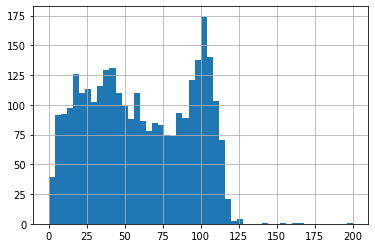

In [15]:
df.review.str.split().str.len().hist(bins=50, range=[0,200])

In [16]:
from statistics import mean
mean(df.review.str.split().str.len())

60.160333333333334

In [17]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

In [18]:
#Lets  use a max sequence of 100

In [19]:
df['rating'].drop_duplicates()

0     10.0
1      5.0
2      6.0
4      1.0
5      8.0
6      9.0
16     7.0
18     2.0
19     3.0
20     4.0
Name: rating, dtype: float64

# Remap the review using de NPS score criteria 

Assuming that this score was given based on the client opinion we can identify three distinct kind of clientes: Promotor, Neutro, detractor, so we need to map the rating into three new ranges, based on the NPS criteria

In [20]:
df.loc[df['rating'].isin([1,2]),'nps']=0
df.loc[df['rating'].isin([3,4,5,6,7,8]),'nps']=1
df.loc[df['rating'].isin([9,10]),'nps']=2

In [21]:
arr = df['nps'].astype(int).values

labels= np.zeros((len(df), int(df.nps.max())+1))
labels[np.arange((len(df))), arr] = 1
labels, arr

(array([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([2, 1, 1, ..., 1, 1, 2]))

In [22]:
X=df['review'].values
y=labels

In [23]:
#y = keras.utils.to_categorical(y)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=21)

In [25]:
words_count=set()
pd.DataFrame(X_train)[0].str.split().apply(words_count.update)

0       None
1       None
2       None
3       None
4       None
        ... 
2395    None
2396    None
2397    None
2398    None
2399    None
Name: 0, Length: 2400, dtype: object

In [26]:
len(words_count)

9349

In [27]:
X_train.shape, X_test.shape, y_train.shape

((2400,), (600,), (2400, 3))

In [28]:
max_words=2500
max_len=200

In [29]:
tokens=Tokenizer(num_words=max_words)
tokens.fit_on_texts(X_train)

In [30]:
def text_to_sequence(x):
    sequences= tokens.texts_to_sequences(x)
    return sequence.pad_sequences(sequences, maxlen=max_len)

In [31]:
X_train_seq=text_to_sequence(X_train)

In [32]:
X_test_seq=text_to_sequence(X_test)

In [33]:
X_train_seq.shape, y_train.shape


((2400, 200), (2400, 3))

In [34]:
model = keras.Sequential()
model.add(Embedding(max_words, 128 ,input_length=max_len))
model.add(LSTM(4))
model.add(Dense(labels.shape[1], activation='softmax'))
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5), metrics=[keras.metrics.AUC()])

epochs=10
batch_size=8

2022-06-13 12:02:10.660792: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 12:02:10.661501: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [35]:
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 2128      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 15        
Total params: 322,143
Trainable params: 322,143
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
callback=callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history=model.fit(X_train_seq, y_train, epochs=6, batch_size=batch_size,validation_data=(X_test_seq, y_test),workers=-1,
                 callbacks=[callback])

Train on 2400 samples, validate on 600 samples
Epoch 1/6
2400/2400 [==============================] - 465s 194ms/step - loss: 1.0861 - auc_1: 0.6113 - val_loss: 1.0750 - val_auc_1: 0.6147
Epoch 2/6
2400/2400 [==============================] - 532s 222ms/step - loss: 1.0515 - auc_1: 0.6413 - val_loss: 1.0493 - val_auc_1: 0.6170
Epoch 3/6
2400/2400 [==============================] - 947s 395ms/step - loss: 1.0178 - auc_1: 0.6659 - val_loss: 1.0324 - val_auc_1: 0.6401
Epoch 4/6
2400/2400 [==============================] - 875s 364ms/step - loss: 0.9843 - auc_1: 0.7064 - val_loss: 1.0144 - val_auc_1: 0.6649
Epoch 5/6
2400/2400 [==============================] - 561s 234ms/step - loss: 0.9433 - auc_1: 0.7313 - val_loss: 0.9900 - val_auc_1: 0.6833
Epoch 6/6
2400/2400 [==============================] - 810s 338ms/step - loss: 0.8996 - auc_1: 0.7538 - val_loss: 0.9770 - val_auc_1: 0.6900


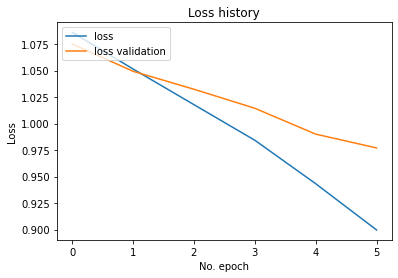

In [37]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='loss validation')
plt.title('Loss history')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [38]:
y_pred=model.predict(X_test_seq)

In [39]:
y_pred_ = tf.one_hot(tf.argmax(y_pred, axis=1), depth = 3)

In [40]:
y_pred_=y_pred_.numpy()

In [41]:
history.history

{'val_loss': [1.0750314664840699,
  1.049297308921814,
  1.0323658005396525,
  1.0144251863161722,
  0.9900214711825053,
  0.9769920563697815],
 'val_auc_1': [0.6147201061248779,
  0.6169770956039429,
  0.6400882005691528,
  0.6648777723312378,
  0.6833479404449463,
  0.6899563074111938],
 'loss': [1.086131414969762,
  1.051462404926618,
  1.0178363305330276,
  0.9842594496409098,
  0.9432629712422689,
  0.8996436325709025],
 'auc_1': [0.6112824, 0.6413297, 0.66587037, 0.7063506, 0.73126006, 0.7538452]}

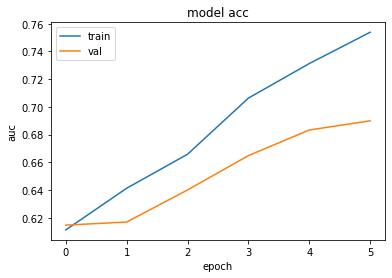

In [43]:
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('model acc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(checkpoint_dir+'/val_ac_'+str(history.history['val_accuracy'][-1])+'.png')
plt.show()


In [44]:
print(sklearn.metrics.classification_report(y_test, y_pred_, digits=5))

              precision    recall  f1-score   support

           0    0.71429   0.08547   0.15267       117
           1    0.33333   0.12264   0.17931       212
           2    0.43504   0.81550   0.56739       271

   micro avg    0.42833   0.42833   0.42833       600
   macro avg    0.49422   0.34120   0.29979       600
weighted avg    0.45356   0.42833   0.34940       600
 samples avg    0.42833   0.42833   0.42833       600

